# COMP472: Artificial Intelligence - Image Classification Project: CIFAR-10 Dataset

## Andrei Mihaescu, No group, 40139389

## 1. Project Introduction: Image Classification

This project tackles image classification on the CIFAR-10 dataset with Python and PyTorch. It uses and analyzes four AI models: Naive Bayes, Decision Tree, Multi-Layer Perceptron (MLP), and Convolutional Neural Network (CNN). Metrics such as accuracy, confusion matrix, precision, and recall are utilized in evaluation.

This study combines conventional and new AI methodologies, providing us with skills applicable to real-world difficulties such as autonomous vehicles and medical imaging.

Imports for the whole project

In [2]:
# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# torchvision
import torchvision
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, ToPILImage, transforms

# sklearn
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Other utilities
import os
import numpy as np
from collections import Counter
import pandas as pd
import pickle
from joblib import dump
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gdown
from google.colab import files

In [3]:
# Utility Functions
def print_classification_metrics(true_labels, predictions, model_name):
    """Print classification metrics for a given model."""
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

def plot_confusion_matrix(true_labels, predictions, model_name, class_labels):
    """Plot a confusion matrix for a given model."""
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [4]:
# Run this file with GPU if possible (much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Dataset Overview

The CIFAR-10 dataset contains 50,000 training and 10,000 test RGB images belonging to 10 object classes.
Images are of size 32 × 32 × 3.

*   In this project, only 500 training images and 100 testing images will be used per class (5000 training, 1000 testing, 6000 images in total)
*   The CIFAR-10 samples are not in order, so we must parse through the dataset entries and associate them with the correct label set.
*   We might end up parsing through more than 5000 entries if images correspond to an already full set.
*   To help computations in this file, we will try using the GPU when possible, as it is much faster than the CPU

In [5]:
# Raw CIFAR-10 Data (for CNN use)
raw_train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, transform=None, download=True
)
raw_test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, transform=None, download=True
)

# Extract raw data into lists
raw_train_data = [(img, label) for img, label in raw_train_dataset]
raw_test_data = [(img, label) for img, label in raw_test_dataset]

# Print the size of the raw data
print(f"Raw train data size: {len(raw_train_data)} samples")
print(f"Raw test data size: {len(raw_test_data)} samples")

100%|██████████| 170M/170M [00:01<00:00, 100MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Raw train data size: 50000 samples
Raw test data size: 10000 samples


In [6]:
# Filter Raw CIFAR-10 data
def filter_raw_dataset(raw_data, num_samples_per_class):
    class_counts = {i: 0 for i in range(10)}
    filtered_data = []
    filtered_labels = []
    samples_collected = 0

    for img, label in raw_data:
        if class_counts[label] < num_samples_per_class:
            filtered_data.append(ToTensor()(img))  # Convert PIL image to tensor
            filtered_labels.append(label)
            class_counts[label] += 1
            samples_collected += 1

        if samples_collected >= num_samples_per_class * 10:
            break

    return torch.stack(filtered_data), torch.tensor(filtered_labels)

# Apply filtering directly to raw data
filtered_raw_train_data, filtered_raw_train_labels = filter_raw_dataset(raw_train_data, 500)
filtered_raw_test_data, filtered_raw_test_labels = filter_raw_dataset(raw_test_data, 100)

# Print sizes of filtered raw data
print(f"Filtered raw train data size: {filtered_raw_train_data.shape}, labels size: {filtered_raw_train_labels.shape}")
print(f"Filtered raw test data size: {filtered_raw_test_data.shape}, labels size: {filtered_raw_test_labels.shape}")

Filtered raw train data size: torch.Size([5000, 3, 32, 32]), labels size: torch.Size([5000])
Filtered raw test data size: torch.Size([1000, 3, 32, 32]), labels size: torch.Size([1000])


In [7]:
# Transformed CIFAR dataset
# Define transforms: Resize and normalize images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Download CIFAR-10 dataset with transforms applied
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, transform=transform, download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Filter transformed dataset
def filter_dataset(dataset, num_samples_per_class, batch_size=32):
    class_counts = {i: 0 for i in range(10)}
    filtered_data = []
    filtered_targets = []
    total_samples_needed = 10 * num_samples_per_class
    samples_collected = 0

    # Use DataLoader for batch processing
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    progress_bar = tqdm(total=total_samples_needed, desc="Collecting Samples")

    for images, labels in data_loader:
        for img, label in zip(images, labels):
            class_label = label.item()

            if class_counts[class_label] < num_samples_per_class:
                filtered_data.append(img)
                filtered_targets.append(label)
                class_counts[class_label] += 1
                samples_collected += 1
                progress_bar.update(1)

            if samples_collected >= total_samples_needed:
                progress_bar.close()
                return torch.stack(filtered_data), torch.tensor(filtered_targets)

    progress_bar.close()
    return torch.stack(filtered_data), torch.tensor(filtered_targets)

# Apply filtering to transformed data
train_data, train_labels = filter_dataset(train_dataset, 500)
test_data, test_labels = filter_dataset(test_dataset, 100)

# Print filtered data sizes
print(f"\nFiltered train data size: {train_data.shape}, test data size: {test_data.shape}")


Filtered train data size: torch.Size([5000, 3, 224, 224]), test data size: torch.Size([1000, 3, 224, 224])


*   Using pre-trained ResNet-18 on ImageNet with transfer learning, we can reuse learned features on the CIFAR-10 images.
*   CIFAR-10 images have 224x224x3 images, while ResNet-18 squeezes them to 512x1
*   The output of ResNet-18 is more representative than raw pixel data, improving performance of our classifiers.

In [9]:
weights = ResNet18_Weights.DEFAULT  # using the latest weights
model = resnet18(weights=weights)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the fully connected layer (512x1 output)
model = model.to(device)
model.eval()

# Extract features for train and test datasets
def extract_features(model, data, dataset_name="Dataset"):
    features = []
    print(f"Extracting features for {dataset_name}...")

    with torch.no_grad():
        for img in tqdm(data, desc=f"Extracting {dataset_name} Features"):
            img = img.unsqueeze(0).to(device)
            feature = model(img).squeeze()
            features.append(feature.cpu().numpy())

    return np.array(features)

train_features = extract_features(model, train_data, dataset_name="Training Dataset")
test_features = extract_features(model, test_data, dataset_name="Testing Dataset")

print(f"\nExtracted train features: {train_features.shape}, test features: {test_features.shape}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


Extracting features for Training Dataset...


Extracting Training Dataset Features: 100%|██████████| 5000/5000 [00:16<00:00, 303.56it/s]


Extracting features for Testing Dataset...


Extracting Testing Dataset Features: 100%|██████████| 1000/1000 [00:03<00:00, 318.03it/s]


Extracted train features: (5000, 512), test features: (1000, 512)


*   In order to further reduce computational stress on the used classifiers, we apply to PCA to reduce features from 512x1 to 50x1 size.

In [10]:
pca = PCA(n_components=50)
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)

print(f"Reduced train features: {train_features_pca.shape}, test features: {test_features_pca.shape}")

Reduced train features: (5000, 50), test features: (1000, 50)


In [11]:
# Save raw and pca transformed data
torch.save((filtered_raw_train_data, filtered_raw_train_labels), "filtered_raw_train_data.pt")
torch.save((filtered_raw_test_data, filtered_raw_test_labels), "filtered_raw_test_data.pt")
np.save("train_features_pca.npy", train_features_pca)
np.save("test_features_pca.npy", test_features_pca)

# download
files.download("filtered_raw_train_data.pt")
files.download("filtered_raw_test_data.pt")
files.download("train_features_pca.npy")
files.download("test_features_pca.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. Naive Bayes

*   Implement the Gaussian Naive Bayes algorithm in Python.

In [ ]:
class GaussianNaiveBayes:
    def __init__(self):
        self.classes = None
        self.mean = {}
        self.var = {}
        self.priors = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = np.mean(X_c, axis=0)
            self.var[c] = np.var(X_c, axis=0)
            self.priors[c] = X_c.shape[0] / X.shape[0]

    def predict(self, X):
        predictions = [self._predict_single(x) for x in X]
        return np.array(predictions)

    def _predict_single(self, x):
        posteriors = []
        for c in self.classes:
            prior = np.log(self.priors[c])
            likelihood = np.sum(self._gaussian_likelihood(c, x))  # Sum log of Gaussian likelihoods
            posterior = prior + likelihood
            posteriors.append(posterior)
        return self.classes[np.argmax(posteriors)]

    def _gaussian_likelihood(self, c, x):
        mean = self.mean[c]
        var = self.var[c]
        numerator = -0.5 * ((x - mean) ** 2) / (var + 1e-9)
        denominator = -0.5 * np.log(2 * np.pi * (var + 1e-9))
        return numerator + denominator

In [ ]:
# Train and test using custom Naive Bayes
custom_nb = GaussianNaiveBayes()
custom_nb.fit(train_features_pca, train_labels)
custom_nb_predictions = custom_nb.predict(test_features_pca)

*   Implement the Gaussian Naive Bayes algorithm using Scikit's classifier

In [ ]:
# Train and test using Scikit-Learn Gaussian Naive Bayes
scikit_nb = GaussianNB()
scikit_nb.fit(train_features_pca, train_labels)
scikit_nb_predictions = scikit_nb.predict(test_features_pca)

In [ ]:
# Save models
with open("custom_nb_model.pkl", "wb") as f:
    pickle.dump(custom_nb, f)
print("Custom Naive Bayes model saved as 'custom_nb_model.pkl'.")

dump(scikit_nb, "scikit_nb_model.joblib")
print("Scikit-Learn Naive Bayes model saved as 'scikit_nb_model.joblib'.")

files.download("custom_nb_model.pkl")
files.download("scikit_nb_model.joblib")

Custom Naive Bayes model saved as 'custom_nb_model.pkl'.
Scikit-Learn Naive Bayes model saved as 'scikit_nb_model.joblib'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

*   Evaluate both Naive Bayes models on the test set of CIFAR-10 and compare results.


Custom Naive Bayes Metrics:
Accuracy: 0.80
Precision: 0.80
Recall: 0.80
F1-Score: 0.80


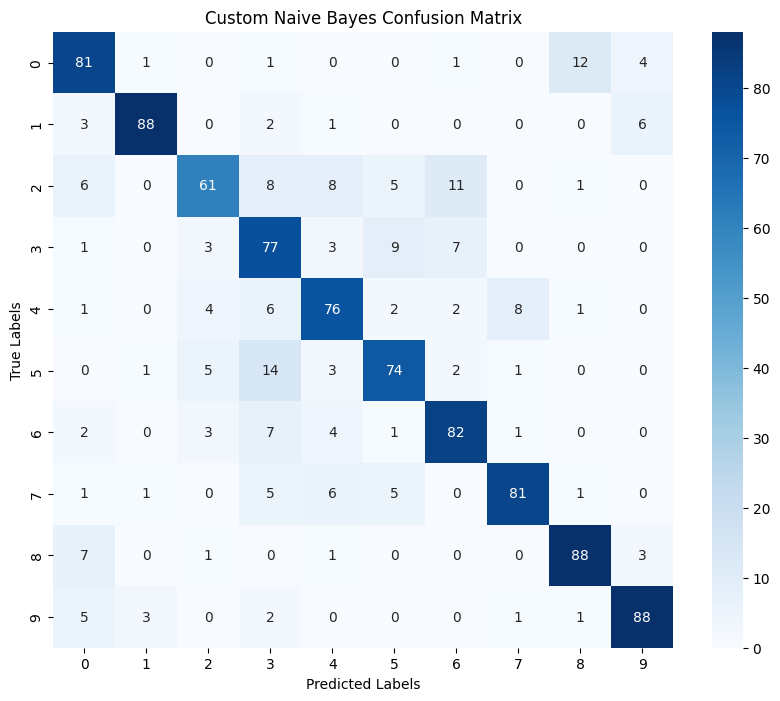


Scikit-Learn Naive Bayes Metrics:
Accuracy: 0.80
Precision: 0.80
Recall: 0.80
F1-Score: 0.80


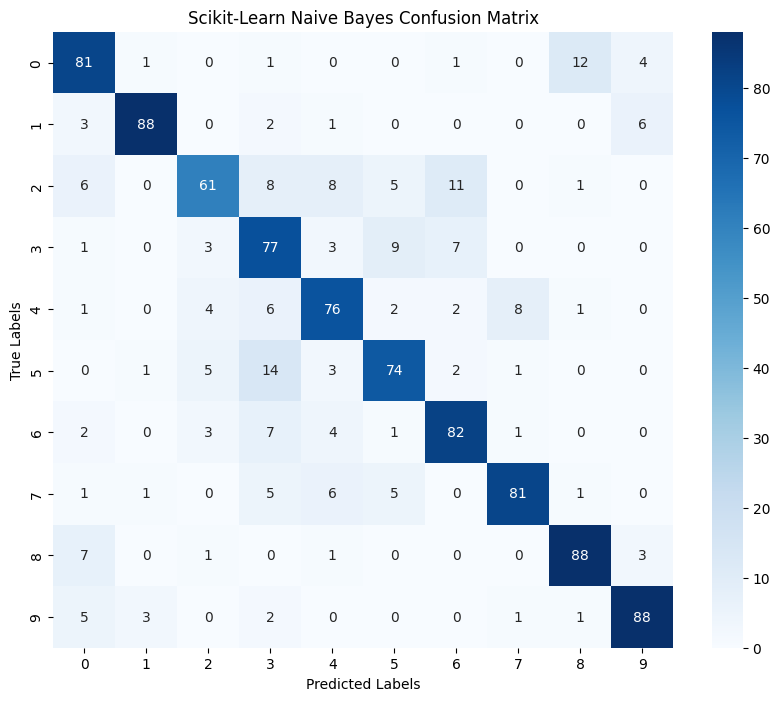


Evaluation Summary:
                      Model  Accuracy  Precision  Recall  F1-Score
0        Custom Naive Bayes     0.796   0.801129   0.796  0.796248
1  Scikit-Learn Naive Bayes     0.796   0.801129   0.796  0.796248


In [ ]:
# Class labels for confusion matrix
class_labels = np.unique(test_labels)

# Custom Naive Bayes
print_classification_metrics(test_labels, custom_nb_predictions, "Custom Naive Bayes")
plot_confusion_matrix(test_labels, custom_nb_predictions, "Custom Naive Bayes", class_labels)

# Scikit-Learn Naive Bayes
print_classification_metrics(test_labels, scikit_nb_predictions, "Scikit-Learn Naive Bayes")
plot_confusion_matrix(test_labels, scikit_nb_predictions, "Scikit-Learn Naive Bayes", class_labels)

# Summary table
custom_nb_metrics = [
    accuracy_score(test_labels, custom_nb_predictions),
    precision_score(test_labels, custom_nb_predictions, average='weighted'),
    recall_score(test_labels, custom_nb_predictions, average='weighted'),
    f1_score(test_labels, custom_nb_predictions, average='weighted'),
]

scikit_nb_metrics = [
    accuracy_score(test_labels, scikit_nb_predictions),
    precision_score(test_labels, scikit_nb_predictions, average='weighted'),
    recall_score(test_labels, scikit_nb_predictions, average='weighted'),
    f1_score(test_labels, scikit_nb_predictions, average='weighted'),
]

results = pd.DataFrame(
    {
        "Model": ["Custom Naive Bayes", "Scikit-Learn Naive Bayes"],
        "Accuracy": [custom_nb_metrics[0], scikit_nb_metrics[0]],
        "Precision": [custom_nb_metrics[1], scikit_nb_metrics[1]],
        "Recall": [custom_nb_metrics[2], scikit_nb_metrics[2]],
        "F1-Score": [custom_nb_metrics[3], scikit_nb_metrics[3]],
    }
)

print("\nEvaluation Summary:")
print(results)

## 4. Decision Tree

*   Implement the Decision Tree algorithm in Python.

In [ ]:
#tuning max_depth, min_samples_leaf and min_gini_improvement can help reduce overfitting (better accuracy) and reduce computation cost (better time performance)
class CustomDecisionTree:
    def __init__(self, max_depth=50, min_samples_leaf=5, min_gini_improvement=0.01):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_gini_improvement = min_gini_improvement
        self.tree = None
        print(f"[INIT] DecisionTree initialized with max_depth={max_depth}, min_samples_leaf={min_samples_leaf}, min_gini_improvement={min_gini_improvement}")

    def gini(self, labels):
        counts = np.bincount(labels)
        probabilities = counts / len(labels)
        return 1 - np.sum(probabilities**2)

    def split(self, data, labels, feature, threshold):
        left_mask = data[:, feature] <= threshold
        right_mask = ~left_mask
        return data[left_mask], labels[left_mask], data[right_mask], labels[right_mask]

    def find_best_split(self, data, labels):
        best_gini = float('inf')
        best_split = None
        n_samples, n_features = data.shape

        for feature in range(n_features):
            thresholds = np.linspace(np.min(data[:, feature]), np.max(data[:, feature]), 10)
            for threshold in thresholds:
                X_left, y_left, X_right, y_right = self.split(data, labels, feature, threshold)

                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue

                gini_split = (len(y_left) / n_samples) * self.gini(y_left) + \
                             (len(y_right) / n_samples) * self.gini(y_right)

                if gini_split < best_gini:
                    improvement = best_gini - gini_split
                    if improvement > self.min_gini_improvement:
                        best_gini = gini_split
                        best_split = {'feature': feature, 'threshold': threshold}
        return best_split

    def build_tree(self, data, labels, depth=0):
        if depth == self.max_depth or len(np.unique(labels)) == 1:
            return Counter(labels).most_common(1)[0][0]

        best_split = self.find_best_split(data, labels)
        if best_split is None:
            return Counter(labels).most_common(1)[0][0]

        feature = best_split['feature']
        threshold = best_split['threshold']
        X_left, y_left, X_right, y_right = self.split(data, labels, feature, threshold)

        return {
            'feature': feature,
            'threshold': threshold,
            'left': self.build_tree(X_left, y_left, depth + 1),
            'right': self.build_tree(X_right, y_right, depth + 1)
        }

    def fit(self, data, labels):
        print("[FIT] Starting tree training...")
        self.tree = self.build_tree(data, labels)
        print("[FIT] Tree training complete.")

    def predict_one(self, x):
        node = self.tree
        while isinstance(node, dict):
            if x[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node

    def predict(self, data):
        print("[PREDICT] Starting predictions...")
        return np.array([self.predict_one(x) for x in data])

In [ ]:
# Train and evaluate the custom decision tree
custom_tree = CustomDecisionTree(max_depth=50)
custom_tree.fit(train_features_pca, train_labels)
custom_tree_predictions = custom_tree.predict(test_features_pca)

[INIT] DecisionTree initialized with max_depth=50, min_samples_leaf=5, min_gini_improvement=0.01
[FIT] Starting tree training...
[FIT] Tree training complete.
[PREDICT] Starting predictions...



Custom Decision Tree Metrics:
Accuracy: 0.59
Precision: 0.59
Recall: 0.59
F1-Score: 0.59


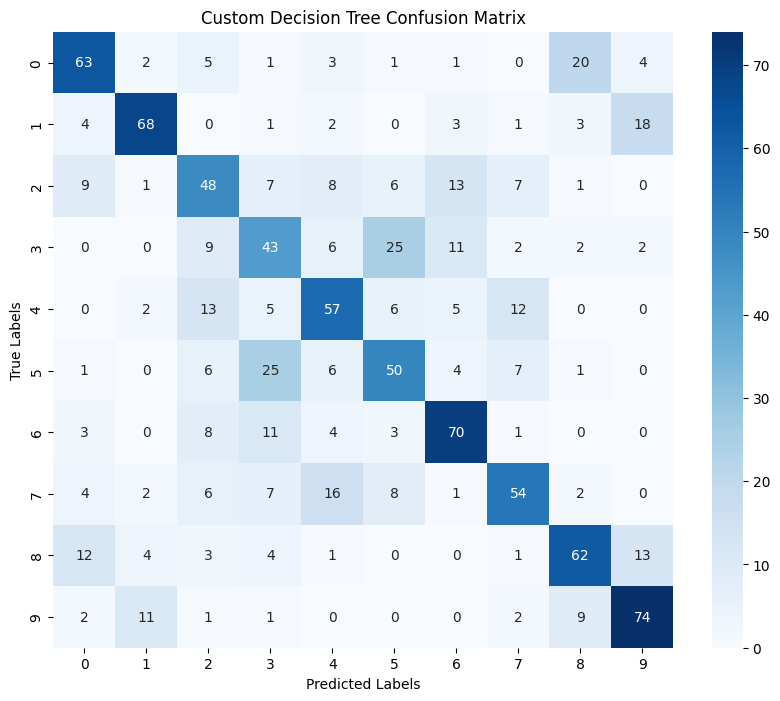

In [ ]:
# Evaluate Custom Decision Tree
print_classification_metrics(test_labels, custom_tree_predictions, "Custom Decision Tree")
plot_confusion_matrix(test_labels, custom_tree_predictions, "Custom Decision Tree", class_labels=np.unique(test_labels))



*   Experiment by varying the depth of the tree.



[INIT] DecisionTree initialized with max_depth=10, min_samples_leaf=5, min_gini_improvement=0.01
[FIT] Starting tree training...
[FIT] Tree training complete.
[PREDICT] Starting predictions...
Depth: 10, Accuracy: 0.59
[INIT] DecisionTree initialized with max_depth=25, min_samples_leaf=5, min_gini_improvement=0.01
[FIT] Starting tree training...
[FIT] Tree training complete.
[PREDICT] Starting predictions...
Depth: 25, Accuracy: 0.59
[INIT] DecisionTree initialized with max_depth=50, min_samples_leaf=5, min_gini_improvement=0.01
[FIT] Starting tree training...
[FIT] Tree training complete.
[PREDICT] Starting predictions...
Depth: 50, Accuracy: 0.59


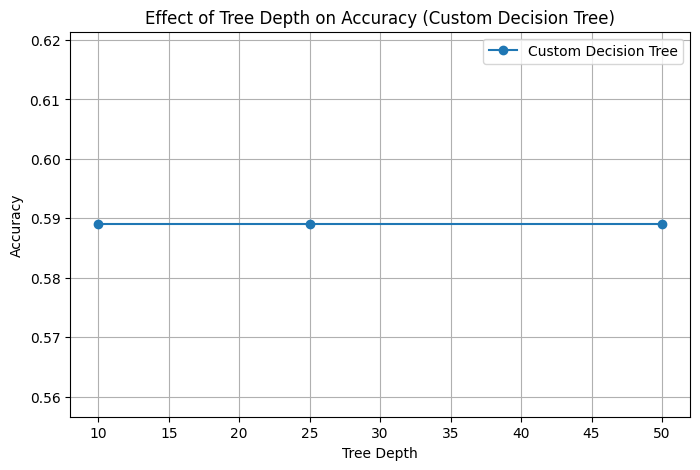

In [ ]:
# Experiment with varying depths
depths = [10, 25, 50]
custom_accuracies = []

for depth in depths:
    tree = CustomDecisionTree(max_depth=depth)
    tree.fit(train_features_pca, train_labels)
    predictions = tree.predict(test_features_pca)
    accuracy = accuracy_score(test_labels, predictions)
    custom_accuracies.append(accuracy)
    print(f"Depth: {depth}, Accuracy: {accuracy:.2f}")

# Plot accuracy vs. depth
plt.figure(figsize=(8, 5))
plt.plot(depths, custom_accuracies, label="Custom Decision Tree", marker='o')
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Effect of Tree Depth on Accuracy (Custom Decision Tree)")
plt.legend()
plt.grid()
plt.show()



*   Implement a Decision Tree algorithm using SciKitLearn's implementation and evaluate performance




Scikit-Learn Decision Tree Metrics:
Accuracy: 0.61
Precision: 0.60
Recall: 0.61
F1-Score: 0.60


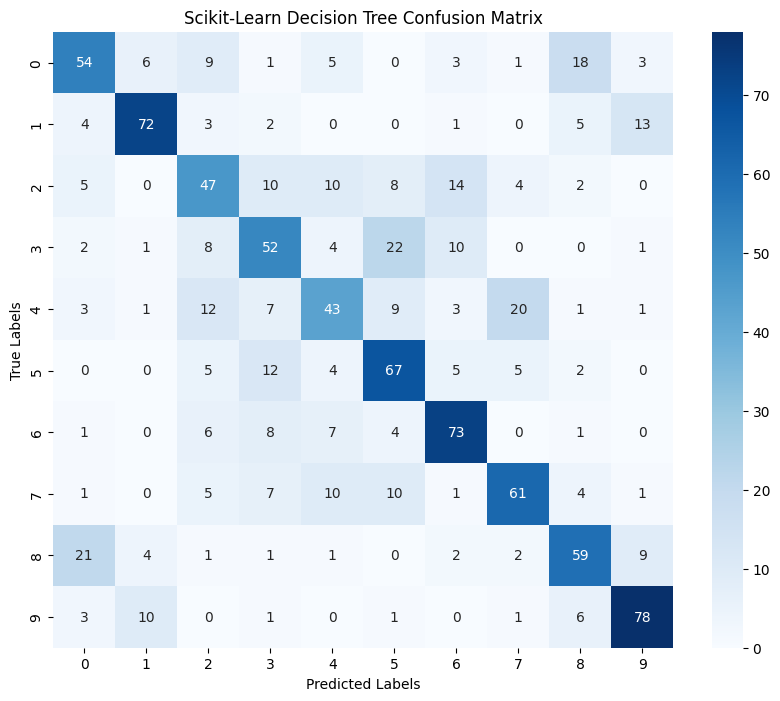

In [ ]:
# Scikit-Learn Decision Tree
sklearn_tree = DecisionTreeClassifier(max_depth=50, random_state=42)
sklearn_tree.fit(train_features_pca, train_labels)
sklearn_tree_predictions = sklearn_tree.predict(test_features_pca)

# Evaluate Scikit-Learn Decision Tree
print_classification_metrics(test_labels, sklearn_tree_predictions, "Scikit-Learn Decision Tree")
plot_confusion_matrix(test_labels, sklearn_tree_predictions, "Scikit-Learn Decision Tree", class_labels=np.unique(test_labels))

In [ ]:
# Save models
custom_tree_model_path = "custom_decision_tree.pkl"
with open(custom_tree_model_path, 'wb') as f:
    pickle.dump(custom_tree, f)
print(f"Custom Decision Tree model saved to {custom_tree_model_path}")

sklearn_tree_model_path = "sklearn_decision_tree.joblib"
dump(sklearn_tree, sklearn_tree_model_path)
print(f"Scikit-Learn Decision Tree model saved to {sklearn_tree_model_path}")

files.download(custom_tree_model_path)
files.download(sklearn_tree_model_path)

Custom Decision Tree model saved to custom_decision_tree.pkl
Scikit-Learn Decision Tree model saved to sklearn_decision_tree.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Summarize metrics for Decision Trees
custom_tree_metrics = [
    accuracy_score(test_labels, custom_tree_predictions),
    precision_score(test_labels, custom_tree_predictions, average='weighted'),
    recall_score(test_labels, custom_tree_predictions, average='weighted'),
    f1_score(test_labels, custom_tree_predictions, average='weighted'),
]

sklearn_tree_metrics = [
    accuracy_score(test_labels, sklearn_tree_predictions),
    precision_score(test_labels, sklearn_tree_predictions, average='weighted'),
    recall_score(test_labels, sklearn_tree_predictions, average='weighted'),
    f1_score(test_labels, sklearn_tree_predictions, average='weighted'),
]

results_tree_comp = pd.DataFrame(
    {
        "Model": ["Custom Decision Tree", "Scikit-Learn Decision Tree"],
        "Accuracy": [custom_tree_metrics[0], sklearn_tree_metrics[0]],
        "Precision": [custom_tree_metrics[1], sklearn_tree_metrics[1]],
        "Recall": [custom_tree_metrics[2], sklearn_tree_metrics[2]],
        "F1-Score": [custom_tree_metrics[3], sklearn_tree_metrics[3]],
    }
)

print("\nEvaluation Summary:")
print(results_dt_comp)


Evaluation Summary:
                        Model  Accuracy  Precision  Recall  F1-Score
0        Custom Decision Tree     0.589   0.590674   0.589  0.589021
1  Scikit-Learn Decision Tree     0.606   0.604910   0.606  0.604049


## 5. Multi-Layer Perceptron (MLP)

*   Implement the 3-layer MLP algorithm in Python, Numpy and Pytorch.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size=50, hidden_size=512, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.batchnorm(self.fc2(x))
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Reusable training function
def train_and_evaluate_mlp(model, train_loader, test_loader, criterion, optimizer, num_epochs=20):
    """
    Train the MLP model and return predictions and true labels for evaluation.

    Parameters:
        model (nn.Module): The MLP model to train.
        train_loader (DataLoader): DataLoader for training data.
        test_loader (DataLoader): DataLoader for test data.
        criterion: Loss function (e.g., CrossEntropyLoss).
        optimizer: Optimizer (e.g., SGD).
        num_epochs (int): Number of epochs to train.

    Returns:
        dict: Dictionary containing predictions and true labels.
    """
    # Training phase
    model.train()
    print(f"[TRAIN] Starting training for {num_epochs} epochs.")
    for epoch in range(num_epochs):
        running_loss = 0.0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            outputs = model(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Evaluation phase
    print("[EVALUATE] Starting evaluation on test data.")
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            outputs = model(features)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.numpy())

    return {"predictions": predictions, "true_labels": true_labels}

In [ ]:
# Prepare CIFAR-10 DataLoader with reduced features
train_dataset = TensorDataset(torch.tensor(train_features_pca, dtype=torch.float32),
                              torch.tensor(train_labels, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(test_features_pca, dtype=torch.float32),
                             torch.tensor(test_labels, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

<ipython-input-59-784646916acb>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_labels, dtype=torch.long))
<ipython-input-59-784646916acb>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(test_labels, dtype=torch.long))


[TRAIN] Starting training for 20 epochs.
Epoch [1/20], Loss: 0.7540
Epoch [2/20], Loss: 0.4218
Epoch [3/20], Loss: 0.3243
Epoch [4/20], Loss: 0.2706
Epoch [5/20], Loss: 0.2275
Epoch [6/20], Loss: 0.1875
Epoch [7/20], Loss: 0.1630
Epoch [8/20], Loss: 0.1204
Epoch [9/20], Loss: 0.0961
Epoch [10/20], Loss: 0.0687
Epoch [11/20], Loss: 0.0636
Epoch [12/20], Loss: 0.0679
Epoch [13/20], Loss: 0.0747
Epoch [14/20], Loss: 0.0679
Epoch [15/20], Loss: 0.0347
Epoch [16/20], Loss: 0.0297
Epoch [17/20], Loss: 0.0208
Epoch [18/20], Loss: 0.0182
Epoch [19/20], Loss: 0.0238
Epoch [20/20], Loss: 0.0164
[EVALUATE] Starting evaluation on test data.

MLP Metrics:
Accuracy: 0.82
Precision: 0.83
Recall: 0.82
F1-Score: 0.82


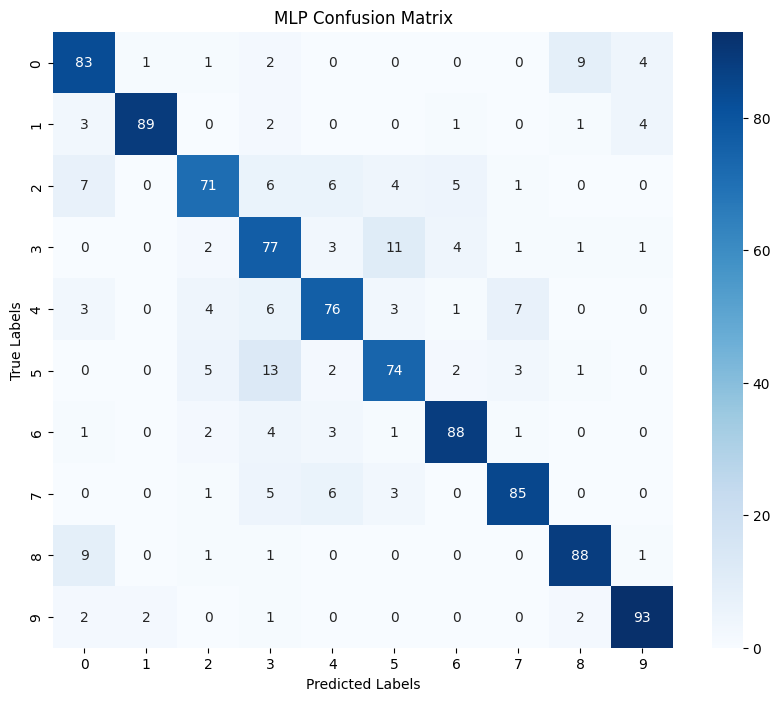

In [ ]:
# Define the MLP model and training configuration
mlp_model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01, momentum=0.9)

# Train and evaluate the base MLP model
results_mlp = train_and_evaluate_mlp(mlp_model, train_loader, test_loader, criterion, optimizer, num_epochs=20)

# Use utility functions to print metrics and confusion matrix
class_labels = np.unique(test_labels)
print_classification_metrics(results_mlp["true_labels"], results_mlp["predictions"], "MLP")
plot_confusion_matrix(results_mlp["true_labels"], results_mlp["predictions"], "MLP", class_labels)




*   Experiment by varying the depth of the network by adding or removing layers.
*   Vary the sizes of the hidden layers



In [ ]:
# Save the MLP model in .pth format
torch.save(mlp_model.state_dict(), "mlp_model.pth")
print("MLP model saved as 'mlp_model.pth'.")

# Download the file to the local machine
files.download("mlp_model.pth")

MLP model saved as 'mlp_model.pth'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Experimenting with hidden layer size: 256
[TRAIN] Starting training for 20 epochs.
Epoch [1/20], Loss: 0.8940
Epoch [2/20], Loss: 0.4546
Epoch [3/20], Loss: 0.3814
Epoch [4/20], Loss: 0.3309
Epoch [5/20], Loss: 0.2881
Epoch [6/20], Loss: 0.2509
Epoch [7/20], Loss: 0.2243
Epoch [8/20], Loss: 0.1830
Epoch [9/20], Loss: 0.1528
Epoch [10/20], Loss: 0.1271
Epoch [11/20], Loss: 0.1167
Epoch [12/20], Loss: 0.1054
Epoch [13/20], Loss: 0.0797
Epoch [14/20], Loss: 0.0891
Epoch [15/20], Loss: 0.0817
Epoch [16/20], Loss: 0.0803
Epoch [17/20], Loss: 0.0584
Epoch [18/20], Loss: 0.0593
Epoch [19/20], Loss: 0.0402
Epoch [20/20], Loss: 0.0404
[EVALUATE] Starting evaluation on test data.
Hidden Layer Size 256, Accuracy: 0.82000

Experimenting with hidden layer size: 512
[TRAIN] Starting training for 20 epochs.
Epoch [1/20], Loss: 0.7672
Epoch [2/20], Loss: 0.4148
Epoch [3/20], Loss: 0.3356
Epoch [4/20], Loss: 0.2699
Epoch [5/20], Loss: 0.2162
Epoch [6/20], Loss: 0.1785
Epoch [7/20], Loss: 0.1417
Epoch 

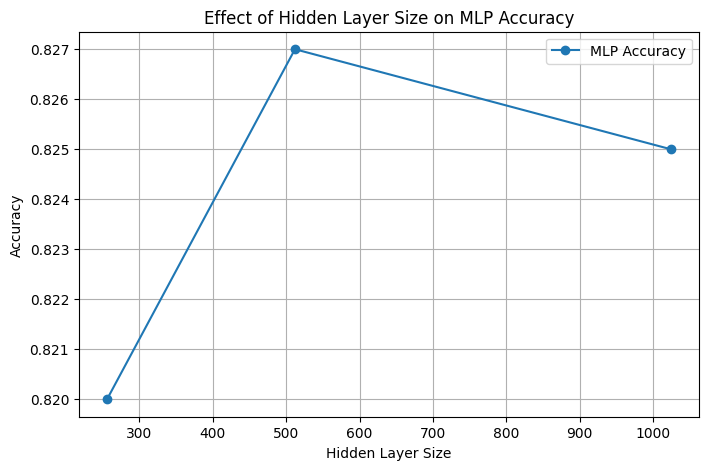

In [ ]:
# Experimentation with varying hidden layer sizes
hidden_layer_sizes = [256, 512, 1024]  # Experiment with varying sizes
mlp_accuracies = []

for size in hidden_layer_sizes:
    print(f"\nExperimenting with hidden layer size: {size}")

    # Define and train the MLP model with the current hidden layer size
    experiment_model = MLP(hidden_size=size).to(device)
    optimizer = optim.SGD(experiment_model.parameters(), lr=0.01, momentum=0.9)
    experiment_results = train_and_evaluate_mlp(
        experiment_model,
        train_loader,
        test_loader,
        criterion,
        optimizer,
        num_epochs=20
    )

    # Store accuracy for the current configuration
    accuracy = experiment_results["metrics"]["accuracy"]
    mlp_accuracies.append(accuracy)
    print(f"Hidden Layer Size {size}, Accuracy: {accuracy:.5f}")

# Plot the results of varying hidden layer sizes
plt.figure(figsize=(8, 5))
plt.plot(hidden_layer_sizes, mlp_accuracies, marker='o', label="MLP Accuracy")
plt.xlabel("Hidden Layer Size")
plt.ylabel("Accuracy")
plt.title("Effect of Hidden Layer Size on MLP Accuracy")
plt.legend()
plt.grid()
plt.show()

## 6. Convolutional Neural Network (CNN)

*   Implement and train a VGG11 net algorithm in Python, Numpy and Pytorch.

In [ ]:
# As per project guidelines...
class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            # Conv(001, 064, 3, 1, 1) - BatchNorm(064) - ReLU - MaxPool(2, 2)
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv(064, 128, 3, 1, 1) - BatchNorm(128) - ReLU - MaxPool(2, 2)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv(128, 256, 3, 1, 1) - BatchNorm(256) - ReLU
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Conv(256, 256, 3, 1, 1) - BatchNorm(256) - ReLU - MaxPool(2, 2)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv(256, 512, 3, 1, 1) - BatchNorm(512) - ReLU
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            # Linear(0512, 4096) - ReLU - Dropout(0.5)
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            # Linear(4096, 4096) - ReLU - Dropout(0.5)
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            # Linear(4096, 10)
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
def train_and_evaluate_cnn(model, train_loader, test_loader, criterion, optimizer, num_epochs=20):
    """Train CNN model and return predictions and true labels."""
    # Training phase
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(train_loader):.4f}")

    # Evaluation phase
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.numpy())

    return {"predictions": predictions, "true_labels": true_labels}

In [ ]:
# Create DataLoader instances for filtered train and test datasets
# Use raw images from dataset (Not ResNet18 + PCA features)
train_dataset = TensorDataset(filtered_raw_train_data, filtered_raw_train_labels)
test_dataset = TensorDataset(filtered_raw_test_data, filtered_raw_test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Epoch 1/20: 100%|██████████| 79/79 [00:00<00:00, 130.48it/s]


Epoch [1/20] Loss: 1.9289


Epoch 2/20: 100%|██████████| 79/79 [00:00<00:00, 135.57it/s]


Epoch [2/20] Loss: 1.5893


Epoch 3/20: 100%|██████████| 79/79 [00:00<00:00, 137.78it/s]


Epoch [3/20] Loss: 1.3811


Epoch 4/20: 100%|██████████| 79/79 [00:00<00:00, 134.96it/s]


Epoch [4/20] Loss: 1.2398


Epoch 5/20: 100%|██████████| 79/79 [00:00<00:00, 120.79it/s]


Epoch [5/20] Loss: 1.0643


Epoch 6/20: 100%|██████████| 79/79 [00:00<00:00, 137.26it/s]


Epoch [6/20] Loss: 0.8806


Epoch 7/20: 100%|██████████| 79/79 [00:00<00:00, 137.61it/s]


Epoch [7/20] Loss: 0.7452


Epoch 8/20: 100%|██████████| 79/79 [00:00<00:00, 139.00it/s]


Epoch [8/20] Loss: 0.6613


Epoch 9/20: 100%|██████████| 79/79 [00:00<00:00, 135.33it/s]


Epoch [9/20] Loss: 0.6770


Epoch 10/20: 100%|██████████| 79/79 [00:00<00:00, 137.71it/s]


Epoch [10/20] Loss: 0.4562


Epoch 11/20: 100%|██████████| 79/79 [00:00<00:00, 136.65it/s]


Epoch [11/20] Loss: 0.4002


Epoch 12/20: 100%|██████████| 79/79 [00:00<00:00, 135.45it/s]


Epoch [12/20] Loss: 0.4038


Epoch 13/20: 100%|██████████| 79/79 [00:00<00:00, 134.62it/s]


Epoch [13/20] Loss: 0.3818


Epoch 14/20: 100%|██████████| 79/79 [00:00<00:00, 134.95it/s]


Epoch [14/20] Loss: 0.2335


Epoch 15/20: 100%|██████████| 79/79 [00:00<00:00, 137.51it/s]


Epoch [15/20] Loss: 0.1976


Epoch 16/20: 100%|██████████| 79/79 [00:00<00:00, 136.01it/s]


Epoch [16/20] Loss: 0.1470


Epoch 17/20: 100%|██████████| 79/79 [00:00<00:00, 136.19it/s]


Epoch [17/20] Loss: 0.1452


Epoch 18/20: 100%|██████████| 79/79 [00:00<00:00, 137.60it/s]


Epoch [18/20] Loss: 0.0633


Epoch 19/20: 100%|██████████| 79/79 [00:00<00:00, 137.69it/s]


Epoch [19/20] Loss: 0.1123


Epoch 20/20: 100%|██████████| 79/79 [00:00<00:00, 136.89it/s]


Epoch [20/20] Loss: 0.0928

VGG11 Metrics:
Accuracy: 0.60
Precision: 0.63
Recall: 0.60
F1-Score: 0.60


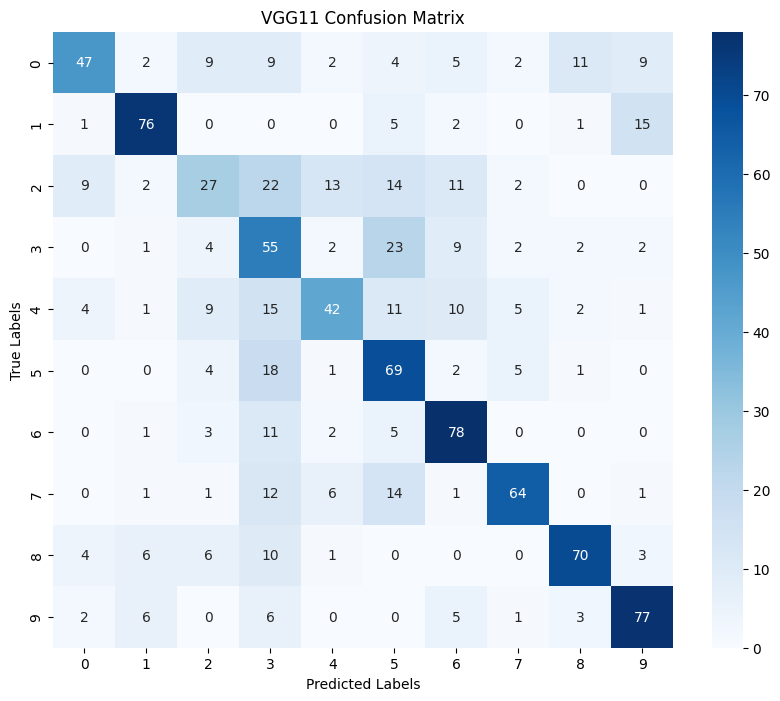

In [ ]:
vgg11_model = VGG11(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg11_model.parameters(), lr=0.01, momentum=0.9)

results_cnn = train_and_evaluate_cnn(vgg11_model, train_loader, test_loader, criterion, optimizer, num_epochs=20)

print_classification_metrics(results_cnn["true_labels"], results_cnn["predictions"], "VGG11")
plot_confusion_matrix(results_cnn["true_labels"], results_cnn["predictions"], "VGG11", class_labels=range(10))

In [ ]:
# Save the VGG11 model
model_path = "vgg11_model.pth"
torch.save(vgg11_model.state_dict(), model_path)
print(f"VGG11 model saved as '{model_path}'.")

files.download(model_path)

VGG11 model saved as 'vgg11_model.pth'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


[TRAINING] VGG9


Epoch 1/20: 100%|██████████| 79/79 [00:00<00:00, 128.46it/s]


Epoch [1/20] Loss: 1.9075


Epoch 2/20: 100%|██████████| 79/79 [00:00<00:00, 134.85it/s]


Epoch [2/20] Loss: 1.5647


Epoch 3/20: 100%|██████████| 79/79 [00:00<00:00, 132.15it/s]


Epoch [3/20] Loss: 1.3437


Epoch 4/20: 100%|██████████| 79/79 [00:00<00:00, 135.28it/s]


Epoch [4/20] Loss: 1.1920


Epoch 5/20: 100%|██████████| 79/79 [00:00<00:00, 136.28it/s]


Epoch [5/20] Loss: 1.0507


Epoch 6/20: 100%|██████████| 79/79 [00:00<00:00, 131.73it/s]


Epoch [6/20] Loss: 0.9037


Epoch 7/20: 100%|██████████| 79/79 [00:00<00:00, 132.11it/s]


Epoch [7/20] Loss: 0.7971


Epoch 8/20: 100%|██████████| 79/79 [00:00<00:00, 129.35it/s]


Epoch [8/20] Loss: 0.6534


Epoch 9/20: 100%|██████████| 79/79 [00:00<00:00, 134.63it/s]


Epoch [9/20] Loss: 0.7572


Epoch 10/20: 100%|██████████| 79/79 [00:00<00:00, 135.96it/s]


Epoch [10/20] Loss: 0.6010


Epoch 11/20: 100%|██████████| 79/79 [00:00<00:00, 134.89it/s]


Epoch [11/20] Loss: 0.4632


Epoch 12/20: 100%|██████████| 79/79 [00:00<00:00, 135.51it/s]


Epoch [12/20] Loss: 0.3419


Epoch 13/20: 100%|██████████| 79/79 [00:00<00:00, 135.05it/s]


Epoch [13/20] Loss: 0.3509


Epoch 14/20: 100%|██████████| 79/79 [00:00<00:00, 135.45it/s]


Epoch [14/20] Loss: 0.2417


Epoch 15/20: 100%|██████████| 79/79 [00:00<00:00, 134.69it/s]


Epoch [15/20] Loss: 0.2677


Epoch 16/20: 100%|██████████| 79/79 [00:00<00:00, 136.33it/s]


Epoch [16/20] Loss: 0.1457


Epoch 17/20: 100%|██████████| 79/79 [00:00<00:00, 136.88it/s]


Epoch [17/20] Loss: 0.1753


Epoch 18/20: 100%|██████████| 79/79 [00:00<00:00, 135.58it/s]


Epoch [18/20] Loss: 0.1725


Epoch 19/20: 100%|██████████| 79/79 [00:00<00:00, 135.47it/s]


Epoch [19/20] Loss: 0.0648


Epoch 20/20: 100%|██████████| 79/79 [00:00<00:00, 134.33it/s]


Epoch [20/20] Loss: 0.1570
VGG9 Accuracy: 0.58

[TRAINING] VGG11


Epoch 1/20: 100%|██████████| 79/79 [00:00<00:00, 135.77it/s]


Epoch [1/20] Loss: 1.9691


Epoch 2/20: 100%|██████████| 79/79 [00:00<00:00, 134.08it/s]


Epoch [2/20] Loss: 1.5838


Epoch 3/20: 100%|██████████| 79/79 [00:00<00:00, 136.77it/s]


Epoch [3/20] Loss: 1.3786


Epoch 4/20: 100%|██████████| 79/79 [00:00<00:00, 137.61it/s]


Epoch [4/20] Loss: 1.2210


Epoch 5/20: 100%|██████████| 79/79 [00:00<00:00, 137.85it/s]


Epoch [5/20] Loss: 1.0831


Epoch 6/20: 100%|██████████| 79/79 [00:00<00:00, 135.17it/s]


Epoch [6/20] Loss: 0.9419


Epoch 7/20: 100%|██████████| 79/79 [00:00<00:00, 132.46it/s]


Epoch [7/20] Loss: 0.7688


Epoch 8/20: 100%|██████████| 79/79 [00:00<00:00, 134.17it/s]


Epoch [8/20] Loss: 0.7080


Epoch 9/20: 100%|██████████| 79/79 [00:00<00:00, 137.52it/s]


Epoch [9/20] Loss: 0.5730


Epoch 10/20: 100%|██████████| 79/79 [00:00<00:00, 136.51it/s]


Epoch [10/20] Loss: 0.5346


Epoch 11/20: 100%|██████████| 79/79 [00:00<00:00, 135.10it/s]


Epoch [11/20] Loss: 0.4153


Epoch 12/20: 100%|██████████| 79/79 [00:00<00:00, 135.13it/s]


Epoch [12/20] Loss: 0.3640


Epoch 13/20: 100%|██████████| 79/79 [00:00<00:00, 136.68it/s]


Epoch [13/20] Loss: 0.3267


Epoch 14/20: 100%|██████████| 79/79 [00:00<00:00, 135.05it/s]


Epoch [14/20] Loss: 0.2617


Epoch 15/20: 100%|██████████| 79/79 [00:00<00:00, 137.73it/s]


Epoch [15/20] Loss: 0.2496


Epoch 16/20: 100%|██████████| 79/79 [00:00<00:00, 132.30it/s]


Epoch [16/20] Loss: 0.1537


Epoch 17/20: 100%|██████████| 79/79 [00:00<00:00, 134.60it/s]


Epoch [17/20] Loss: 0.2067


Epoch 18/20: 100%|██████████| 79/79 [00:00<00:00, 134.84it/s]


Epoch [18/20] Loss: 0.2091


Epoch 19/20: 100%|██████████| 79/79 [00:00<00:00, 131.94it/s]


Epoch [19/20] Loss: 0.0778


Epoch 20/20: 100%|██████████| 79/79 [00:00<00:00, 135.73it/s]


Epoch [20/20] Loss: 0.1059
VGG11 Accuracy: 0.61

[TRAINING] VGG13


Epoch 1/20: 100%|██████████| 79/79 [00:00<00:00, 123.75it/s]


Epoch [1/20] Loss: 1.8951


Epoch 2/20: 100%|██████████| 79/79 [00:00<00:00, 124.35it/s]


Epoch [2/20] Loss: 1.5443


Epoch 3/20: 100%|██████████| 79/79 [00:00<00:00, 127.36it/s]


Epoch [3/20] Loss: 1.3479


Epoch 4/20: 100%|██████████| 79/79 [00:00<00:00, 123.01it/s]


Epoch [4/20] Loss: 1.1760


Epoch 5/20: 100%|██████████| 79/79 [00:00<00:00, 122.16it/s]


Epoch [5/20] Loss: 1.0636


Epoch 6/20: 100%|██████████| 79/79 [00:00<00:00, 120.41it/s]


Epoch [6/20] Loss: 0.9368


Epoch 7/20: 100%|██████████| 79/79 [00:00<00:00, 117.24it/s]


Epoch [7/20] Loss: 0.7502


Epoch 8/20: 100%|██████████| 79/79 [00:00<00:00, 124.80it/s]


Epoch [8/20] Loss: 0.6559


Epoch 9/20: 100%|██████████| 79/79 [00:00<00:00, 125.66it/s]


Epoch [9/20] Loss: 0.5366


Epoch 10/20: 100%|██████████| 79/79 [00:00<00:00, 125.95it/s]


Epoch [10/20] Loss: 0.4830


Epoch 11/20: 100%|██████████| 79/79 [00:00<00:00, 124.35it/s]


Epoch [11/20] Loss: 0.3897


Epoch 12/20: 100%|██████████| 79/79 [00:00<00:00, 126.11it/s]


Epoch [12/20] Loss: 0.3864


Epoch 13/20: 100%|██████████| 79/79 [00:00<00:00, 124.94it/s]


Epoch [13/20] Loss: 0.2705


Epoch 14/20: 100%|██████████| 79/79 [00:00<00:00, 126.01it/s]


Epoch [14/20] Loss: 0.2592


Epoch 15/20: 100%|██████████| 79/79 [00:00<00:00, 125.53it/s]


Epoch [15/20] Loss: 0.3324


Epoch 16/20: 100%|██████████| 79/79 [00:00<00:00, 126.75it/s]


Epoch [16/20] Loss: 0.1628


Epoch 17/20: 100%|██████████| 79/79 [00:00<00:00, 125.19it/s]


Epoch [17/20] Loss: 0.2565


Epoch 18/20: 100%|██████████| 79/79 [00:00<00:00, 126.47it/s]


Epoch [18/20] Loss: 0.2406


Epoch 19/20: 100%|██████████| 79/79 [00:00<00:00, 128.24it/s]


Epoch [19/20] Loss: 0.0741


Epoch 20/20: 100%|██████████| 79/79 [00:00<00:00, 126.52it/s]


Epoch [20/20] Loss: 0.0446
VGG13 Accuracy: 0.59


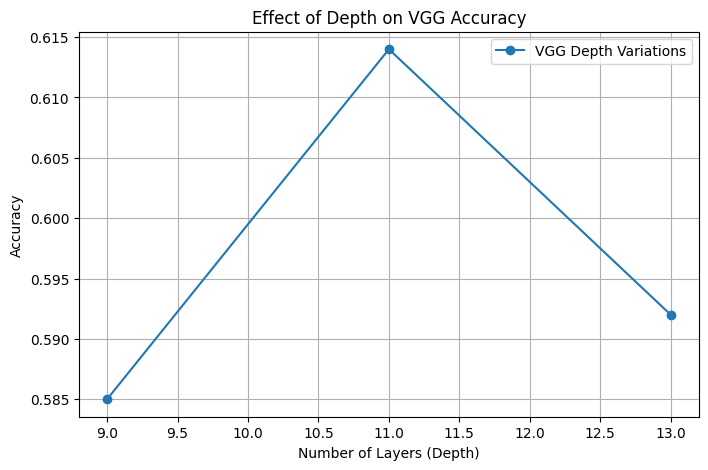

In [ ]:
# Depth exploration (Define various VGG models with deifferent depths)

class VGG9(VGG11):
    def __init__(self, num_classes=10):
        super().__init__(num_classes)
        # Remove last two convolutional blocks
        self.features = nn.Sequential(
            *list(self.features.children())[:-8]
        )
        self.classifier[0] = nn.Linear(8192, 4096)

class VGG11Hardcoded(VGG11):
    pass  # Baseline model

class VGG13(VGG11):
    def __init__(self, num_classes=10):
        super().__init__(num_classes)
        # Add extra convolutional layers to create VGG13
        extra_layers = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.features = nn.Sequential(self.features, extra_layers)

vgg9_model = VGG9(num_classes=10).to(device)
vgg11_model = VGG11Hardcoded(num_classes=10).to(device)
vgg13_model = VGG13(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
num_epochs = 20

depth_accuracies = []

# Train and evaluate VGG9
print("\n[TRAINING] VGG9")
optimizer_vgg9 = optim.SGD(vgg9_model.parameters(), lr=0.01, momentum=0.9)
results_vgg9 = train_and_evaluate_cnn(vgg9_model, train_loader, test_loader, criterion, optimizer_vgg9, num_epochs)
accuracy_vgg9 = accuracy_score(results_vgg9["true_labels"], results_vgg9["predictions"])
depth_accuracies.append((9, accuracy_vgg9))
print(f"VGG9 Accuracy: {accuracy_vgg9:.2f}")

# Train and evaluate VGG11
print("\n[TRAINING] VGG11")
optimizer_vgg11 = optim.SGD(vgg11_model.parameters(), lr=0.01, momentum=0.9)
results_vgg11 = train_and_evaluate_cnn(vgg11_model, train_loader, test_loader, criterion, optimizer_vgg11, num_epochs)
accuracy_vgg11 = accuracy_score(results_vgg11["true_labels"], results_vgg11["predictions"])
depth_accuracies.append((11, accuracy_vgg11))
print(f"VGG11 Accuracy: {accuracy_vgg11:.2f}")

# Train and evaluate VGG13
print("\n[TRAINING] VGG13")
optimizer_vgg13 = optim.SGD(vgg13_model.parameters(), lr=0.01, momentum=0.9)
results_vgg13 = train_and_evaluate_cnn(vgg13_model, train_loader, test_loader, criterion, optimizer_vgg13, num_epochs)
accuracy_vgg13 = accuracy_score(results_vgg13["true_labels"], results_vgg13["predictions"])
depth_accuracies.append((13, accuracy_vgg13))
print(f"VGG13 Accuracy: {accuracy_vgg13:.2f}")

# Plot the results
depths, accuracies = zip(*depth_accuracies)
plt.figure(figsize=(8, 5))
plt.plot(depths, accuracies, marker='o', label="VGG Depth Variations")
plt.xlabel("Number of Layers (Depth)")
plt.ylabel("Accuracy")
plt.title("Effect of Depth on VGG Accuracy")
plt.legend()
plt.grid()
plt.show()



[TRAINING] VGG Kernel Size 3


Epoch 1/20: 100%|██████████| 79/79 [00:00<00:00, 133.46it/s]


Epoch [1/20] Loss: 1.9376


Epoch 2/20: 100%|██████████| 79/79 [00:00<00:00, 136.29it/s]


Epoch [2/20] Loss: 1.5834


Epoch 3/20: 100%|██████████| 79/79 [00:00<00:00, 134.59it/s]


Epoch [3/20] Loss: 1.3779


Epoch 4/20: 100%|██████████| 79/79 [00:00<00:00, 135.90it/s]


Epoch [4/20] Loss: 1.2121


Epoch 5/20: 100%|██████████| 79/79 [00:00<00:00, 137.01it/s]


Epoch [5/20] Loss: 1.1389


Epoch 6/20: 100%|██████████| 79/79 [00:00<00:00, 137.51it/s]


Epoch [6/20] Loss: 0.9098


Epoch 7/20: 100%|██████████| 79/79 [00:00<00:00, 136.76it/s]


Epoch [7/20] Loss: 0.7938


Epoch 8/20: 100%|██████████| 79/79 [00:00<00:00, 138.81it/s]


Epoch [8/20] Loss: 0.6902


Epoch 9/20: 100%|██████████| 79/79 [00:00<00:00, 137.27it/s]


Epoch [9/20] Loss: 0.5816


Epoch 10/20: 100%|██████████| 79/79 [00:00<00:00, 139.04it/s]


Epoch [10/20] Loss: 0.5691


Epoch 11/20: 100%|██████████| 79/79 [00:00<00:00, 137.03it/s]


Epoch [11/20] Loss: 0.4326


Epoch 12/20: 100%|██████████| 79/79 [00:00<00:00, 138.88it/s]


Epoch [12/20] Loss: 0.4320


Epoch 13/20: 100%|██████████| 79/79 [00:00<00:00, 140.21it/s]


Epoch [13/20] Loss: 0.3177


Epoch 14/20: 100%|██████████| 79/79 [00:00<00:00, 137.93it/s]


Epoch [14/20] Loss: 0.2506


Epoch 15/20: 100%|██████████| 79/79 [00:00<00:00, 140.04it/s]


Epoch [15/20] Loss: 0.3764


Epoch 16/20: 100%|██████████| 79/79 [00:00<00:00, 138.74it/s]


Epoch [16/20] Loss: 0.2026


Epoch 17/20: 100%|██████████| 79/79 [00:00<00:00, 138.78it/s]


Epoch [17/20] Loss: 0.1181


Epoch 18/20: 100%|██████████| 79/79 [00:00<00:00, 139.01it/s]


Epoch [18/20] Loss: 0.1086


Epoch 19/20: 100%|██████████| 79/79 [00:00<00:00, 137.63it/s]


Epoch [19/20] Loss: 0.1091


Epoch 20/20: 100%|██████████| 79/79 [00:00<00:00, 139.04it/s]


Epoch [20/20] Loss: 0.1984
Kernel Size 3 Accuracy: 0.61

[TRAINING] VGG Kernel Size 5


Epoch 1/20: 100%|██████████| 79/79 [00:00<00:00, 104.80it/s]


Epoch [1/20] Loss: 2.0238


Epoch 2/20: 100%|██████████| 79/79 [00:00<00:00, 110.94it/s]


Epoch [2/20] Loss: 1.7505


Epoch 3/20: 100%|██████████| 79/79 [00:00<00:00, 108.76it/s]


Epoch [3/20] Loss: 1.5735


Epoch 4/20: 100%|██████████| 79/79 [00:00<00:00, 111.05it/s]


Epoch [4/20] Loss: 1.4500


Epoch 5/20: 100%|██████████| 79/79 [00:00<00:00, 111.32it/s]


Epoch [5/20] Loss: 1.3146


Epoch 6/20: 100%|██████████| 79/79 [00:00<00:00, 111.61it/s]


Epoch [6/20] Loss: 1.1983


Epoch 7/20: 100%|██████████| 79/79 [00:00<00:00, 108.93it/s]


Epoch [7/20] Loss: 1.0998


Epoch 8/20: 100%|██████████| 79/79 [00:00<00:00, 107.24it/s]


Epoch [8/20] Loss: 1.1519


Epoch 9/20: 100%|██████████| 79/79 [00:00<00:00, 110.81it/s]


Epoch [9/20] Loss: 0.9151


Epoch 10/20: 100%|██████████| 79/79 [00:00<00:00, 111.10it/s]


Epoch [10/20] Loss: 0.7946


Epoch 11/20: 100%|██████████| 79/79 [00:00<00:00, 110.78it/s]


Epoch [11/20] Loss: 0.7135


Epoch 12/20: 100%|██████████| 79/79 [00:00<00:00, 110.71it/s]


Epoch [12/20] Loss: 0.5806


Epoch 13/20: 100%|██████████| 79/79 [00:00<00:00, 110.36it/s]


Epoch [13/20] Loss: 0.5699


Epoch 14/20: 100%|██████████| 79/79 [00:00<00:00, 110.85it/s]


Epoch [14/20] Loss: 0.4607


Epoch 15/20: 100%|██████████| 79/79 [00:00<00:00, 109.52it/s]


Epoch [15/20] Loss: 0.6723


Epoch 16/20: 100%|██████████| 79/79 [00:00<00:00, 110.76it/s]


Epoch [16/20] Loss: 0.3865


Epoch 17/20: 100%|██████████| 79/79 [00:00<00:00, 109.96it/s]


Epoch [17/20] Loss: 0.3506


Epoch 18/20: 100%|██████████| 79/79 [00:00<00:00, 107.63it/s]


Epoch [18/20] Loss: 0.3625


Epoch 19/20: 100%|██████████| 79/79 [00:00<00:00, 108.51it/s]


Epoch [19/20] Loss: 0.3417


Epoch 20/20: 100%|██████████| 79/79 [00:00<00:00, 111.17it/s]


Epoch [20/20] Loss: 0.3090
Kernel Size 5 Accuracy: 0.56

[TRAINING] VGG Kernel Size 7


Epoch 1/20: 100%|██████████| 79/79 [00:01<00:00, 74.19it/s]


Epoch [1/20] Loss: 2.1060


Epoch 2/20: 100%|██████████| 79/79 [00:00<00:00, 79.81it/s]


Epoch [2/20] Loss: 1.8423


Epoch 3/20: 100%|██████████| 79/79 [00:00<00:00, 79.80it/s]


Epoch [3/20] Loss: 1.7563


Epoch 4/20: 100%|██████████| 79/79 [00:00<00:00, 79.81it/s]


Epoch [4/20] Loss: 1.6849


Epoch 5/20: 100%|██████████| 79/79 [00:00<00:00, 79.55it/s]


Epoch [5/20] Loss: 1.5916


Epoch 6/20: 100%|██████████| 79/79 [00:00<00:00, 79.49it/s]


Epoch [6/20] Loss: 1.4929


Epoch 7/20: 100%|██████████| 79/79 [00:00<00:00, 79.83it/s]


Epoch [7/20] Loss: 1.3888


Epoch 8/20: 100%|██████████| 79/79 [00:00<00:00, 79.75it/s]


Epoch [8/20] Loss: 1.2874


Epoch 9/20: 100%|██████████| 79/79 [00:00<00:00, 80.51it/s]


Epoch [9/20] Loss: 1.2187


Epoch 10/20: 100%|██████████| 79/79 [00:01<00:00, 78.89it/s]


Epoch [10/20] Loss: 1.1832


Epoch 11/20: 100%|██████████| 79/79 [00:01<00:00, 78.51it/s]


Epoch [11/20] Loss: 1.0490


Epoch 12/20: 100%|██████████| 79/79 [00:00<00:00, 79.14it/s]


Epoch [12/20] Loss: 0.9712


Epoch 13/20: 100%|██████████| 79/79 [00:01<00:00, 76.03it/s]


Epoch [13/20] Loss: 0.9494


Epoch 14/20: 100%|██████████| 79/79 [00:01<00:00, 76.01it/s]


Epoch [14/20] Loss: 0.8028


Epoch 15/20: 100%|██████████| 79/79 [00:01<00:00, 77.56it/s]


Epoch [15/20] Loss: 0.7311


Epoch 16/20: 100%|██████████| 79/79 [00:01<00:00, 78.58it/s]


Epoch [16/20] Loss: 0.7118


Epoch 17/20: 100%|██████████| 79/79 [00:00<00:00, 79.62it/s]


Epoch [17/20] Loss: 0.5716


Epoch 18/20: 100%|██████████| 79/79 [00:00<00:00, 79.39it/s]


Epoch [18/20] Loss: 0.5497


Epoch 19/20: 100%|██████████| 79/79 [00:00<00:00, 79.71it/s]


Epoch [19/20] Loss: 0.4733


Epoch 20/20: 100%|██████████| 79/79 [00:00<00:00, 80.14it/s]


Epoch [20/20] Loss: 0.4489
Kernel Size 7 Accuracy: 0.45


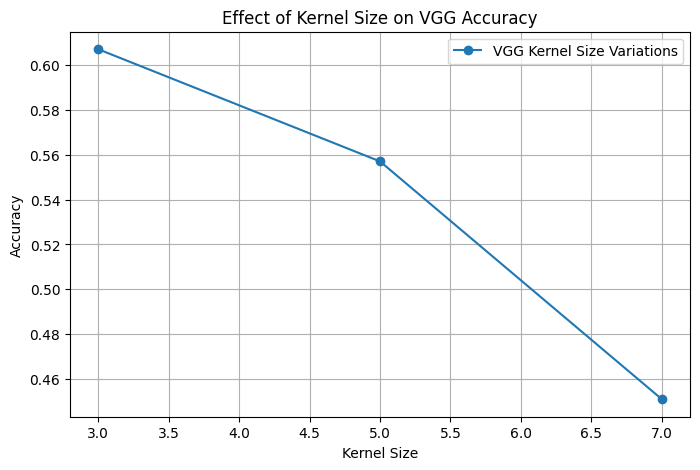

In [ ]:
class VGGKernel3(VGG11):
    def __init__(self, num_classes=10):
        super().__init__(num_classes)
        # Replace all convolutional layers with kernel size 3
        for i, layer in enumerate(self.features):
            if isinstance(layer, nn.Conv2d):
                in_channels = layer.in_channels
                out_channels = layer.out_channels
                stride = layer.stride
                padding = (3 - 1) // 2
                self.features[i] = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding)

class VGGKernel5(VGG11):
    def __init__(self, num_classes=10):
        super().__init__(num_classes)
        # Replace all convolutional layers with kernel size 5
        for i, layer in enumerate(self.features):
            if isinstance(layer, nn.Conv2d):
                in_channels = layer.in_channels
                out_channels = layer.out_channels
                stride = layer.stride
                padding = (5 - 1) // 2
                self.features[i] = nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=stride, padding=padding)

class VGGKernel7(VGG11):
    def __init__(self, num_classes=10):
        super().__init__(num_classes)
        # Replace all convolutional layers with kernel size 7
        for i, layer in enumerate(self.features):
            if isinstance(layer, nn.Conv2d):
                in_channels = layer.in_channels
                out_channels = layer.out_channels
                stride = layer.stride
                padding = (7 - 1) // 2
                self.features[i] = nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=stride, padding=padding)



vgg_kernel3_model = VGGKernel3(num_classes=10).to(device)
vgg_kernel5_model = VGGKernel5(num_classes=10).to(device)
vgg_kernel7_model = VGGKernel7(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
num_epochs = 20

kernel_accuracies = []

# Train and evaluate VGG with kernel size 3
print("\n[TRAINING] VGG Kernel Size 3")
optimizer_vgg_kernel3 = optim.SGD(vgg_kernel3_model.parameters(), lr=0.01, momentum=0.9)
results_kernel3 = train_and_evaluate_cnn(vgg_kernel3_model, train_loader, test_loader, criterion, optimizer_vgg_kernel3, num_epochs)
accuracy_kernel3 = accuracy_score(results_kernel3["true_labels"], results_kernel3["predictions"])
kernel_accuracies.append((3, accuracy_kernel3))
print(f"Kernel Size 3 Accuracy: {accuracy_kernel3:.2f}")

# Train and evaluate VGG with kernel size 5
print("\n[TRAINING] VGG Kernel Size 5")
optimizer_vgg_kernel5 = optim.SGD(vgg_kernel5_model.parameters(), lr=0.01, momentum=0.9)
results_kernel5 = train_and_evaluate_cnn(vgg_kernel5_model, train_loader, test_loader, criterion, optimizer_vgg_kernel5, num_epochs)
accuracy_kernel5 = accuracy_score(results_kernel5["true_labels"], results_kernel5["predictions"])
kernel_accuracies.append((5, accuracy_kernel5))
print(f"Kernel Size 5 Accuracy: {accuracy_kernel5:.2f}")

# Train and evaluate VGG with kernel size 7
print("\n[TRAINING] VGG Kernel Size 7")
optimizer_vgg_kernel7 = optim.SGD(vgg_kernel7_model.parameters(), lr=0.01, momentum=0.9)
results_kernel7 = train_and_evaluate_cnn(vgg_kernel7_model, train_loader, test_loader, criterion, optimizer_vgg_kernel7, num_epochs)
accuracy_kernel7 = accuracy_score(results_kernel7["true_labels"], results_kernel7["predictions"])
kernel_accuracies.append((7, accuracy_kernel7))
print(f"Kernel Size 7 Accuracy: {accuracy_kernel7:.2f}")

# Plot the results
kernel_sizes, accuracies = zip(*kernel_accuracies)
plt.figure(figsize=(8, 5))
plt.plot(kernel_sizes, accuracies, marker='o', label="VGG Kernel Size Variations")
plt.xlabel("Kernel Size")
plt.ylabel("Accuracy")
plt.title("Effect of Kernel Size on VGG Accuracy")
plt.legend()
plt.grid()
plt.show()

## 7. Final Classification Report

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Classification reports
nb_report = classification_report(test_labels, custom_nb_predictions, output_dict=True)
snb_report = classification_report(test_labels, scikit_nb_predictions, output_dict=True)
tree_report = classification_report(test_labels, custom_tree_predictions, output_dict=True)
stree_report = classification_report(test_labels, sklearn_tree_predictions, output_dict=True)
mlp_report = classification_report(test_labels, results_mlp["predictions"], output_dict=True)
cnn_report = classification_report(test_labels, results_cnn["predictions"], output_dict=True)

metrics = {
    "Model": ["Naive Bayes", "SkLearn Naive Bayes", "Decision Tree", "SKLearn Decision Tree", "MLP", "CNN"],
    "Accuracy": [
        round(nb_report["accuracy"], 2),
        round(snb_report["accuracy"], 2),
        round(tree_report["accuracy"], 2),
        round(stree_report["accuracy"], 2),
        round(mlp_report["accuracy"], 2),
        round(cnn_report["accuracy"], 2),
    ],
    "Precision (Weighted)": [
        round(nb_report["weighted avg"]["precision"], 2),
        round(snb_report["weighted avg"]["precision"], 2),
        round(tree_report["weighted avg"]["precision"], 2),
        round(stree_report["weighted avg"]["precision"], 2),
        round(mlp_report["weighted avg"]["precision"], 2),
        round(cnn_report["weighted avg"]["precision"], 2),
    ],
    "Recall (Weighted)": [
        round(nb_report["weighted avg"]["recall"], 2),
        round(snb_report["weighted avg"]["recall"], 2),
        round(tree_report["weighted avg"]["recall"], 2),
        round(stree_report["weighted avg"]["recall"], 2),
        round(mlp_report["weighted avg"]["recall"], 2),
        round(cnn_report["weighted avg"]["recall"], 2),
    ],
    "F1-Score (Weighted)": [
        round(nb_report["weighted avg"]["f1-score"], 2),
        round(snb_report["weighted avg"]["f1-score"], 2),
        round(tree_report["weighted avg"]["f1-score"], 2),
        round(stree_report["weighted avg"]["f1-score"], 2),
        round(mlp_report["weighted avg"]["f1-score"], 2),
        round(cnn_report["weighted avg"]["f1-score"], 2),
    ],
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

                   Model  Accuracy  Precision (Weighted)  Recall (Weighted)  \
0            Naive Bayes      0.80                  0.80               0.80   
1    SkLearn Naive Bayes      0.80                  0.80               0.80   
2          Decision Tree      0.59                  0.59               0.59   
3  SKLearn Decision Tree      0.61                  0.60               0.61   
4                    MLP      0.82                  0.83               0.82   
5                    CNN      0.60                  0.63               0.60   

   F1-Score (Weighted)  
0                 0.80  
1                 0.80  
2                 0.59  
3                 0.60  
4                 0.82  
5                 0.60  
